In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pandas import json_normalize
import numpy as np
from pitch import Pitch 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def load_file(match_id):
    resp = requests.get(f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json")
    match_dict = json.loads(resp.text)
    df = json_normalize(match_dict, sep="_")
    df = df.query("location == location")
    df[['x','y']] = pd.DataFrame(df.location.values.tolist(), index= df.index)
    #Reversing the y-axis co-ordinates because Statsbomb use this reversed co-ordinate system
    df['y'] = 80 - df['y'] 
    df['location'] = df[['x', 'y']].apply(list, axis=1)
    return match_dict, df

match_dict, df = load_file(match_id=7560)

In [32]:
side_dict = {"home": match_dict[0]["team"]["name"],
             "away": match_dict[1]["team"]["name"] }

print(side_dict)

{'home': 'Spain', 'away': 'Morocco'}


In [33]:
side = "away"
lineup = match_dict[1]["tactics"]["lineup"]

In [34]:
class Player:
    def __init__(self, player, df):
        self.id = player["player"]["id"]
        self.name = player["player"]["name"]
        self.average_position(df)

    def average_position(self, df):

        player_pass_df = df.query("(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & (player_id == @self.id) & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
        self.x, self.y = np.mean(player_pass_df['location'].tolist(), axis=0)

        self.n_passes_completed = len(player_pass_df)

In [35]:
player_objs_dict = {}
starters = []
for player in lineup:
    starters.append(player["player"]["name"]) ##To remove all substitutes from our final grouped_df
    p = Player(player, df) ##Calling the Player class
    player_objs_dict.update({player["player"]["name"]: p}) ##For lookup

In [36]:
min_pass_count = 2
total_pass_df = df.query(f"(type_name == 'Pass') & (pass_type_name not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) &"\
                                 f"(team_name == '{side_dict[side]}') & (pass_outcome_name not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])")
total_pass_df = total_pass_df.groupby(["player_name", "pass_recipient_name"]).size().reset_index(name="count")
total_pass_df = total_pass_df.query(" (player_name == @starters) & (pass_recipient_name == @starters) & (count>=@min_pass_count) ")

In [37]:
total_pass_df

,player_name,pass_recipient_name,count
1,Achraf Hakimi Mouh,Hakim Ziyech,5
3,Achraf Hakimi Mouh,Khalid Boutaïb,2
5,Achraf Hakimi Mouh,Mbark Boussoufa,2
7,Achraf Hakimi Mouh,Romain Saïss,2
8,Achraf Hakimi Mouh,Younès Belhanda,5
13,Hakim Ziyech,Achraf Hakimi Mouh,2
16,Hakim Ziyech,Mbark Boussoufa,2
17,Hakim Ziyech,Nabil Dirar,2
18,Hakim Ziyech,Romain Saïss,2
19,Hakim Ziyech,Younès Belhanda,2


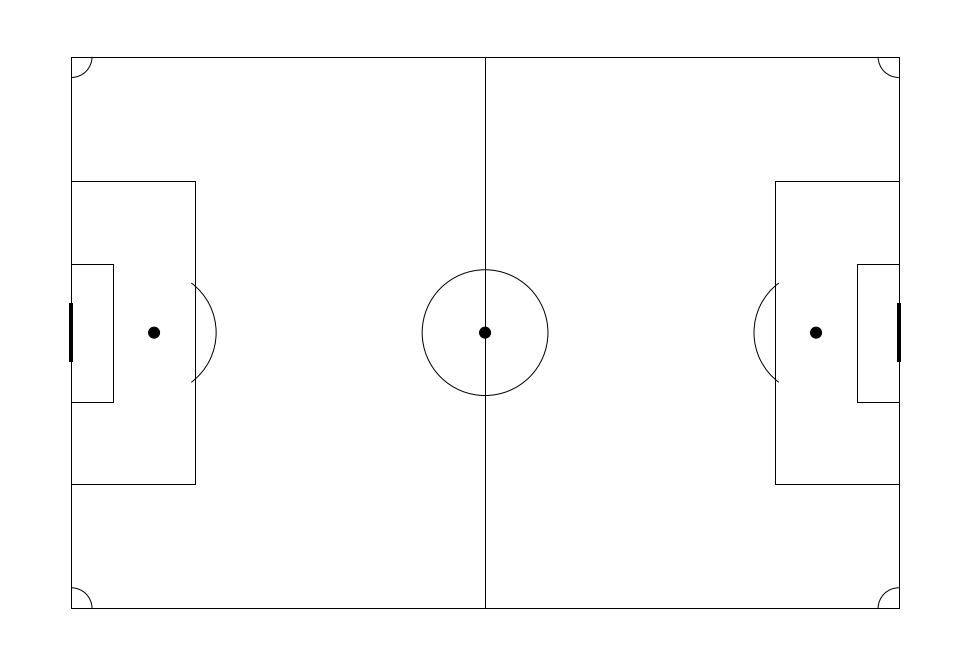

In [38]:
plt.rcParams["figure.figsize"] = (20,12)
fig, ax = plt.subplots()
ax = Pitch(ax)

In [39]:
marker_color = "red"
player_color = "green"
side_color = "red"

In [40]:
##Visualising the passmap
arrow_shift = 1 ##Units by which the arrow moves from its original position
shrink_val = 1.5 ##Units by which the arrow is shortened from the end_points

for row in total_pass_df.itertuples():

    link = row[3] ## for the arrow-width and the alpha
    passer = player_objs_dict[row[1]]
    receiver = player_objs_dict[row[2]]

    alpha = link/15
    if alpha >1:
        alpha=1

    if abs( receiver.x - passer.x) > abs(receiver.y - passer.y):

        if receiver.id > passer.id:
            ax.annotate("", xy=(receiver.x, receiver.y + arrow_shift), xytext=(passer.x, passer.y + arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw = link*0.12, alpha=alpha))

        elif passer.id > receiver.id:
            ax.annotate("", xy=(receiver.x, receiver.y - arrow_shift), xytext=(passer.x, passer.y - arrow_shift),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

    elif abs(receiver.x - passer.x) <= abs(receiver.y - passer.y):

        if receiver.id > passer.id:
            ax.annotate("", xy=(receiver.x + arrow_shift, receiver.y), xytext=(passer.x + arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

        elif passer.id > receiver.id:
            ax.annotate("", xy=(receiver.x - arrow_shift, receiver.y), xytext=(passer.x - arrow_shift, passer.y),
                            arrowprops=dict(arrowstyle="-|>", color="0.25", shrinkA=shrink_val, shrinkB=shrink_val, lw=link*0.12, alpha=alpha))

In [41]:
prevx, prevy = 0 ##storing previous value to check for overlapping players
for name, player in player_objs_dict.items():

    ax.scatter(player.x, player.y, s=player.n_passes_completed*15, color=marker_color, zorder = 4)
    
    if ((round(prevx/3) == round(player.x/3)) and (round(prevy/3) == round(player.y/3))):
        print(name)
        ax.text(player.x, player.y+15, s=player.name.split(" "), rotation=270, va="top" if player.y<40 else "bottom", size=11, fontweight="book", zorder=7, color=player_color)
    else:
        ax.text(player.x, player.y+2 if player.y >40 else player.y -2, s=player.name.split(" "), rotation=270, va="top" if player.y<40 else "bottom", size=11, fontweight="book", zorder=7, color=player_color)
    prevx = player.x
    prevy = player.y
        
ax.text(124, 80, f"{side_dict[side]}", size=24, fontweight="demibold", rotation=270, color=side_color, va="top")
ax.text(122, 80, f"{side_dict['home']} vs {side_dict['away']}", size=16, fontweight="demibold", rotation = 270, va="top")

fig.tight_layout()

Mbark Boussoufa


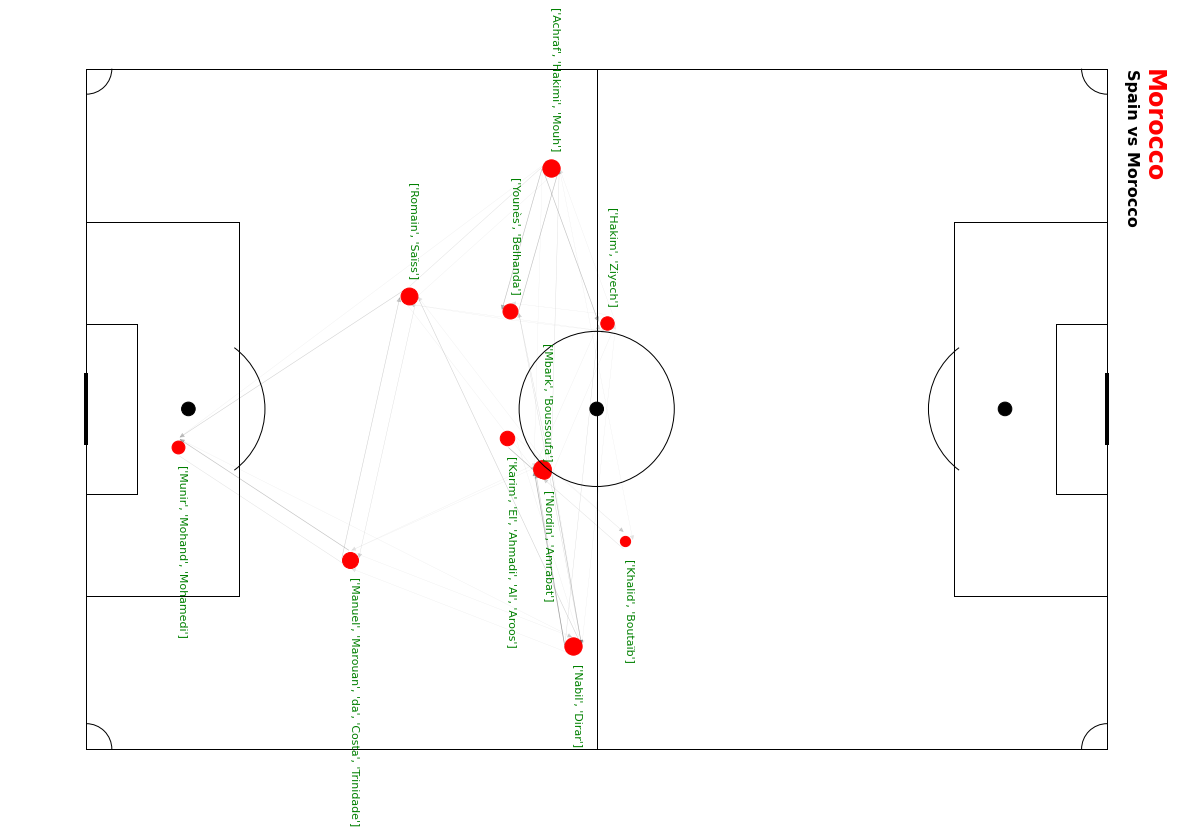

In [42]:
fig.tight_layout()
fig.savefig('./pass_plot.jpg')
fig